In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


In [3]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Project 2/Image2'

def convert_img(img_path):
  img_dir = Path(img_path)
  filepath = list(img_dir.glob(r'**/*.jpg'))
  label  = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],filepath))

  filename = pd.Series(filepath,name='Filepath').astype(str)
  label = pd.Series(label,name='Label')
  img_df = pd.concat([filename,label],axis=1)
  return img_df

img_df = convert_img(img_path)

In [4]:
img_df.head()

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/Dataset...,n02112018-Pomeranian
1,/content/drive/MyDrive/Colab Notebooks/Dataset...,n02112018-Pomeranian
2,/content/drive/MyDrive/Colab Notebooks/Dataset...,n02112018-Pomeranian
3,/content/drive/MyDrive/Colab Notebooks/Dataset...,n02112018-Pomeranian
4,/content/drive/MyDrive/Colab Notebooks/Dataset...,n02112018-Pomeranian


In [5]:
img_df['Label']=img_df['Label'].apply(lambda x:x[10:])

In [6]:
value_c = img_df['Label'].value_counts()

<Axes: >

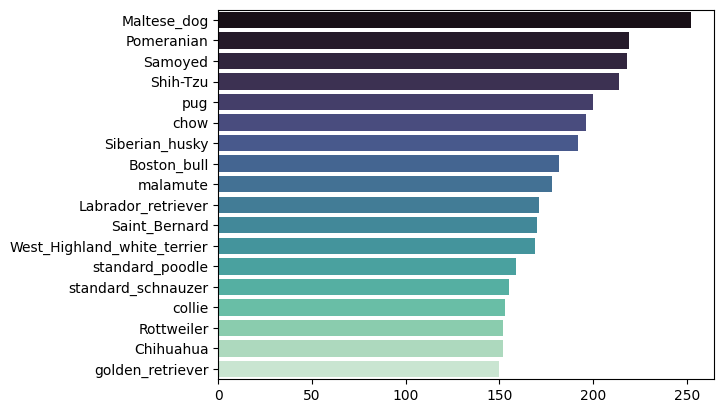

In [7]:
sns.barplot(x=value_c.values, y=value_c.index, palette='mako')

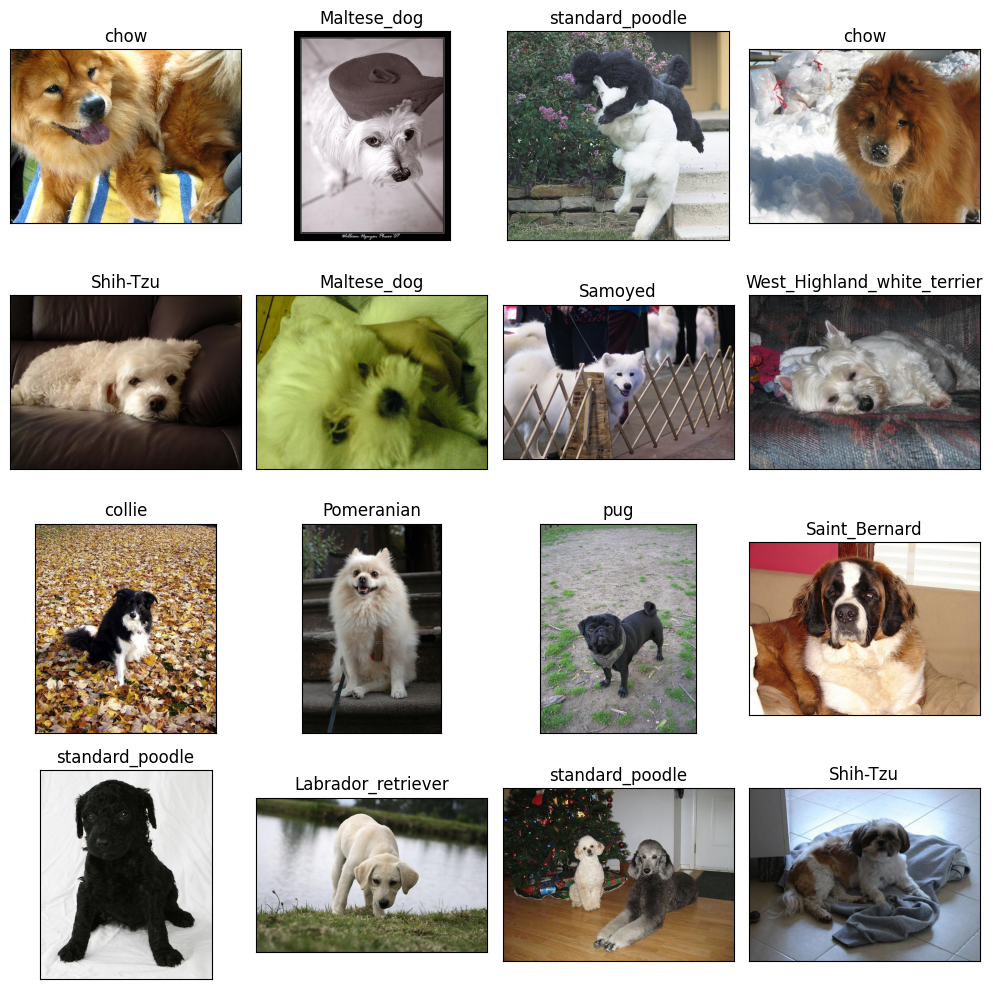

In [8]:
random_index = np.random.randint(0,len(img_df)-1,16)

fig , axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10), subplot_kw={'xticks':[],'yticks':[]})

for i , ax in enumerate(axes.flat):
  img = plt.imread(img_df['Filepath'][random_index[i]])
  ax.imshow(img)
  ax.set_title(img_df['Label'][random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

train_img , test_img =  train_test_split(img_df, test_size=0.1)

train , val = train_test_split(train_img,test_size=0.25)

data_gen = ImageDataGenerator(rescale=1./255)

train_set = data_gen.flow_from_dataframe(dataframe=train,
                                         x_col='Filepath',
                                         y_col='Label',
                                         target_size=(128,128),
                                         batch_size=32,
                                         shuffle=True,
                                         seed=42,
                                         class_mode='categorical')

val_set = data_gen.flow_from_dataframe(dataframe=val,
                                         x_col='Filepath',
                                         y_col='Label',
                                         target_size=(128,128),
                                         batch_size=32,
                                         shuffle=True,
                                         seed=42,
                                         class_mode='categorical')

test_set = data_gen.flow_from_dataframe(dataframe=test_img,
                                         x_col='Filepath',
                                         y_col='Label',
                                         target_size=(128,128),
                                         batch_size=32,
                                         shuffle=False,
                                         seed=42,
                                         class_mode='categorical')

Found 2214 validated image filenames belonging to 18 classes.
Found 739 validated image filenames belonging to 18 classes.
Found 329 validated image filenames belonging to 18 classes.


In [10]:
from keras import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D,Flatten,Dropout

model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(18,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 256)       0         
 g2D)                                                   

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
history = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    epochs=20,
                    verbose=1)

Epoch 1/20
 3/70 [>.............................] - ETA: 11:17 - loss: 6.5844 - accuracy: 0.0729

KeyboardInterrupt: ignored

In [ ]:
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Train',c='g',lw=2.0)
plt.plot(history.history['val_loss'],label='Test',c='r',lw=2.0)
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Train',c='g',lw=2.0)
plt.plot(history.history['val_accuracy'],label='Test',c='r',lw=2.0)
plt.grid()
plt.legend()

In [ ]:
score = model.evaluate(test_set,steps=len(test_set),verbose=0)

In [ ]:
score

#VGG16

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping , ModelCheckpoint

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_set = datagen.flow_from_dataframe(dataframe=train,
                                        x_col='Filepath',
                                        y_col='Label',
                                        target_size=(224,224),
                                        class_mode='categorical',
                                        seed=42,
                                        batch_size=32,
                                        shuffle=True)

test_set = datagen.flow_from_dataframe(dataframe=test_img,
                                        x_col='Filepath',
                                        y_col='Label',
                                        target_size=(224,224),
                                        class_mode='categorical',
                                        seed=42,
                                        batch_size=32,
                                        shuffle=False)

val_set = datagen.flow_from_dataframe(dataframe=val,
                                        x_col='Filepath',
                                        y_col='Label',
                                        target_size=(224,224),
                                        class_mode='categorical',
                                        seed=42,
                                        batch_size=32,
                                        shuffle=True)

In [ ]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
base_model.trainable = False

model_vgg16  = Sequential()
model_vgg16.add(base_model)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256,activation='relu'))
model_vgg16.add(Dense(128,activation='relu'))
model_vgg16.add(Dropout(0.45))
model_vgg16.add(Dense(18,activation='softmax'))

model_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss',patience=100,verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',verbose=1,save_best_only=True)

model_vgg16.summary()

In [ ]:
history_vgg16 = model_vgg16.fit(train_set,
                         steps_per_epoch=len(train_set),
                         validation_data=val_set,
                         validation_steps=len(val_set),
                         verbose=1,
                        callbacks=es,
                         epochs=250)

In [ ]:
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history_vgg16.history['loss'],label="Train",c='g',lw=2.5)
plt.plot(history_vgg16.history['val_loss'],label="Test",c='r',lw=2.5)
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vgg16.history['accuracy'],label="Train",c='g',lw=2.5)
plt.plot(history_vgg16.history['val_accuracy'],label="Test",c='r',lw=2.5)
plt.grid()
plt.legend()
plt.show()

score = model_vgg16.evaluate(test_set,steps=len(test_set),verbose=0)
score

In [ ]:
vbn

#InceptionV3, ResNet

In [ ]:
img_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_set=img_datagen.flow_from_dataframe(dataframe=train,
                                                x_col="Filepath",
                                                y_col="Label",
                                                batch_size=32,
                                                seed=42,
                                                shuffle=True,
                                                class_mode='categorical',
                                                target_size=(299, 299))

val_set=img_datagen.flow_from_dataframe(dataframe=val,
                                              x_col="Filepath",
                                              y_col="Label",
                                              batch_size=32,
                                              seed=42,
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=(299, 299))

test_set=img_datagen.flow_from_dataframe(dataframe=test_img,
                                               x_col="Filepath",
                                               y_col="Label",
                                               batch_size=32,
                                               seed=42,
                                               shuffle=False,
                                               class_mode='categorical',
                                               target_size=(299, 299))

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(299, 299, 3))


In [ ]:
from keras.layers import GlobalAveragePooling2D
model_in = Sequential()
model_in.add(i_model)

model_in.add(GlobalAveragePooling2D())
model_in.add(Dense(128))
model_in.add(Dropout(0.45))
model_in.add(Dense(18, activation = 'softmax'))

model_in.build([None, 224, 224, 3])
model_in.summary()

In [ ]:
model_in.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss',patience=10,verbose=1)

#    fig.patch.set_facecolor('#343434')


In [ ]:
history_in = model_in.fit(train_set,
                    steps_per_epoch=len(train_set),
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=es,
                    epochs=20)

In [ ]:
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history_in.history['loss'],label="Train",c='g',lw=2.5)
plt.plot(history_in.history['val_loss'],label="Test",c='r',lw=2.5)
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_in.history['accuracy'],label="Train",c='g',lw=2.5)
plt.plot(history_in.history['val_accuracy'],label="Test",c='r',lw=2.5)
plt.grid()
plt.legend()
plt.show()

score = model_in.evaluate(test_set,steps=len(test_set),verbose=0)
score